<a href="https://colab.research.google.com/github/ShahzaibSE/langgraph-e2e-solutions/blob/main/2_2_chains_reducers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [4]:
%%capture --no-stderr
%pip install --quiet -U langchain-google-genai langchain_core langgraph

## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation.

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`.

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Let's create a list of messages.

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [5]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from pprint import pprint

messages = [
    AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")
]

messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
  m.pretty_print()


================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message types, as discussed above.

There are [many](https://python.langchain.com/v0.2/docs/concepts/#chat-models) to choose from! Let's work with Gemini.

Let's check that your `GEMINI_API_KEY` is set and, if not, you will be asked to enter it.

In [6]:
from google.colab import userdata

google_api_key = userdata.get('GEMINI_API_KEY')
open_api_key = userdata.get('OPENAI_API_KEY')


We can load a chat model and invoke it with out list of messages.

We can see that the result is an `AIMessage` with specific `response_metadata`.

**Note:** Obtain the necessary json key from the Google Cloud Console by following the instructions outlined in step 21_langchain_ecosystem/langchain/-01_gemini_standalone/Gemini_API_python.ipynb file. Once acquired, load the json key in Google Colab to proceed with the project.

In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI

gemini_llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=google_api_key)

response = gemini_llm.invoke(messages)

In [8]:
type(response)

langchain_core.messages.ai.AIMessage

In [9]:
response.pretty_print()

================================== Ai Message ==================================

There's no single "best" place to see orcas in the US, as it depends on what kind of experience you're looking for and the time of year.  Orcas, or killer whales, have different populations with varying ranges.  However, some of the most popular and reliable locations include:

* **Washington State (San Juan Islands):** This is arguably the most famous and consistently reliable place to see orcas in the US.  The resident orca population, known as the Southern Resident Killer Whales, frequents the waters around the San Juan Islands.  These orcas are easily identifiable and well-studied.  However, their population is critically endangered, so responsible whale watching is crucial.  Tours from Friday Harbor and other towns are readily available.

* **Alaska:**  Alaska boasts several orca populations, including transients and residents.  Opportunities exist throughout the state, but popular areas include Sout

In [10]:
response

AIMessage(content='There\'s no single "best" place to see orcas in the US, as it depends on what kind of experience you\'re looking for and the time of year.  Orcas, or killer whales, have different populations with varying ranges.  However, some of the most popular and reliable locations include:\n\n* **Washington State (San Juan Islands):** This is arguably the most famous and consistently reliable place to see orcas in the US.  The resident orca population, known as the Southern Resident Killer Whales, frequents the waters around the San Juan Islands.  These orcas are easily identifiable and well-studied.  However, their population is critically endangered, so responsible whale watching is crucial.  Tours from Friday Harbor and other towns are readily available.\n\n* **Alaska:**  Alaska boasts several orca populations, including transients and residents.  Opportunities exist throughout the state, but popular areas include Southeast Alaska (Juneau, Ketchikan), Prince William Sound, a

In [11]:
response.response_metadata

{'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
 'finish_reason': 'STOP',
 'safety_ratings': []}

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the tool's schema.

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple.

You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

In [12]:
from langchain_core.tools import Tool

In [13]:
def multiply(a:int, b:int):
  """Multiply a and b.

  Args:
      a: first int
      b: second int
  """
  return a * b

gemini_llm_with_tools: ChatGoogleGenerativeAI = gemini_llm.bind_tools([multiply])

**Note:** Warning indicates that the title key is being generated internally, likely within LangGraph or the Gemini integration when the tool is being bound, rather than being passed explicitly. So ignore the warning


If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a function_call returned.

The function_call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}
```


In [14]:
function_call = gemini_llm_with_tools.invoke([HumanMessage(content="What will be the result of multiplication 3 and 9?", name='Shazy')])
function_call

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 9.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-598cd0f4-3008-4f2a-9a23-979b46ce0c10-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3.0, 'b': 9.0}, 'id': '09575676-27f6-4cec-9dda-962dc79a7c87', 'type': 'tool_call'}], usage_metadata={'input_tokens': 62, 'output_tokens': 3, 'total_tokens': 65, 'input_token_details': {'cache_read': 0}})

In [15]:
function_call.additional_kwargs['function_call']

{'name': 'multiply', 'arguments': '{"a": 3.0, "b": 9.0}'}

In [16]:
# function_call = gemini_llm_with_tools.invoke(HumanMessage(content="What will be the result of multiplication 3 and 2?", name='Shazy'))
function_call = gemini_llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])
function_call

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-a954acb7-5699-4a76-9235-bce664eccfc3-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': '33f574c6-a343-49e9-b6d4-062777ef7e8a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 3, 'total_tokens': 60, 'input_token_details': {'cache_read': 0}})

In [17]:
function_call.additional_kwargs['function_call']

{'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}

## Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [18]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage


class State(TypedDict):
  messages:list[AnyMessage]

## Reducers

Now, we have a minor problem!

As we discussed, each node will return a new value for our state key `messages`.

But, this new value will [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.

As our graph runs, we want to **append** messages to to our `messages` state key.

We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.

But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We annotate simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [19]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
  messages:Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)!

`MessagesState` is defined:

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [20]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

In [21]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Calling Reducer.
add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='72bddb95-bc61-4315-9d17-4c9939eaf802'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='359d9c75-f736-4069-84e1-048301780908'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='e9165d36-9ed3-440c-855b-7c7722d7b012')]

In [25]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph

## **Creating Graph**

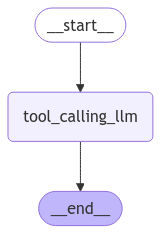

In [36]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

def tool_calling_llm(state:MessagesState):
  return {'messages':gemini_llm_with_tools.invoke(state['messages'])}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
# Adding edges.
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
messages = graph.invoke({'messages': HumanMessage(content="Hello!")})

for message in messages['messages']:
  message.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I help you today?


In [39]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 4 and 2!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 4 and 2!
================================== Ai Message ==================================
Tool Calls:
  multiply (b24f3cad-57e7-4086-8318-cf9c43f43d84)
 Call ID: b24f3cad-57e7-4086-8318-cf9c43f43d84
  Args:
    a: 4.0
    b: 2.0
